## **8.8 Data Augmentation**

This is another way of introducing regularisation into a neural network model and reducing model overfitting. The basic idea is to generate 'new' images from existing images as way of increasing the size of the training dataset without having to collect more images or repeat images.

In [2]:
# !pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

%matplotlib inline

2023-05-13 09:29:09.079685: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# read in the data
root_dir = r'./data/animal_images_small'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

In [3]:
# helper functions pulled directly from keras
def apply_transform(x, transform_parameters):
    x = tf.keras.preprocessing.image.apply_affine_transform(x,
        transform_parameters.get('theta', 0),
        transform_parameters.get('tx', 0),
        transform_parameters.get('ty', 0),
        transform_parameters.get('shear', 0),
        transform_parameters.get('zx', 1),
        transform_parameters.get('zy', 1),
        row_axis=0,
        col_axis=1,
        channel_axis=2,
        fill_mode='nearest',
        cval=0.0,
        order=1
    )

    if transform_parameters.get('flip_horizontal', False):
        x = x[::-1, :, :]

    if transform_parameters.get('flip_vertical', False):
        x = x[:, ::-1, :]

    return x


def augment(img, 
            rotation=0,
            height_shift=0,
            width_shift=0,
            shear=0,
            zoom_x=1,
            zoom_y=1,
            flip_horizontal=0,
            flip_vertical=0):

    x = np.array(img)

    transform_parameters = {
        'theta': rotation,
        'tx': height_shift,
        'ty': width_shift,
        'shear': shear,
        'zx': zoom_x,
        'zy': zoom_y,
        'flip_horizontal': flip_horizontal,
        'flip_vertical': flip_vertical,
    }
    
    xaug = apply_transform(x, transform_parameters)
    imgaug = PIL.Image.fromarray(xaug)
    return imgaug


def show_augmentations(param, values, figsize=(20, 6)):
    imgs = []

    for v in values:
        im = augment(horse, **{param: v})
        imgs.append(im)

    plt.figure(figsize=figsize)

    n = len(values)

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(np.array(imgs[i]))
        plt.title('%s=%s' % (param, values[i]))
        plt.axis("off")

    plt.show()    

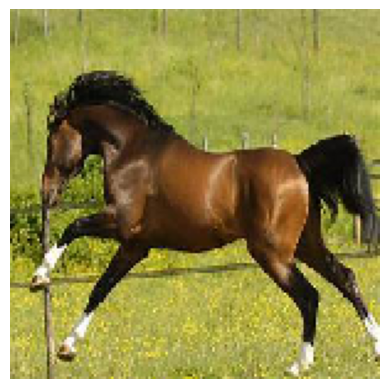

In [4]:
# load an image
horse_dir = os.path.join(train_dir, 'horse')
horse_image = os.listdir(horse_dir)[1]

img = load_img(os.path.join(horse_dir, horse_image), target_size=(150, 150))
plt.imshow(img)
plt.axis("off");

**Flipping**

Note that the second augmentation where the image is upside doesn't make sense in this case and wouldn't occur in a dataset of animal images. That is, the type of augmentations applied need to be sensible for the dataset.

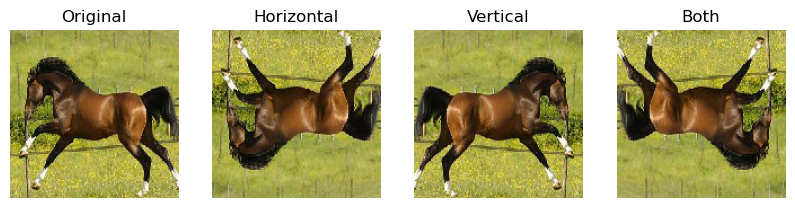

In [5]:
# view different augmentations
plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(np.array(img))
plt.title('Original')
plt.axis("off")

plt.subplot(1, 4, 2)
horse = augment(img, flip_horizontal=1)
plt.imshow(np.array(horse))
plt.title('Horizontal')
plt.axis("off")

plt.subplot(1, 4, 3)
horse = augment(img, flip_vertical=1)
plt.imshow(np.array(horse))
plt.title('Vertical')
plt.axis("off")

plt.subplot(1, 4, 4)
horse = augment(img, flip_horizontal=1, flip_vertical=1)
plt.imshow(np.array(horse))
plt.title('Both')
plt.axis("off")

plt.show() 

## **Rotation**

Note that as some parts of the rotated image are lost and the corners need to be filled in, the augmenter has to make an educated guess as to what the missing bits look like.

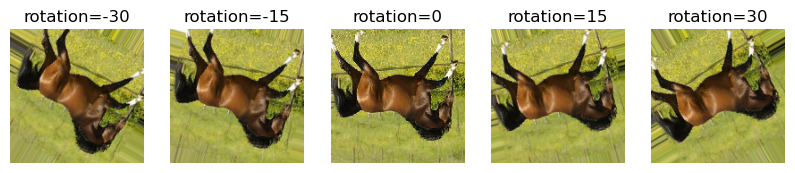

In [6]:
param = 'rotation'
values = [-30, -15, 0, 15, 30]
show_augmentations(param, values, (10, 3))

## **Vertical or Horizontal Shift**

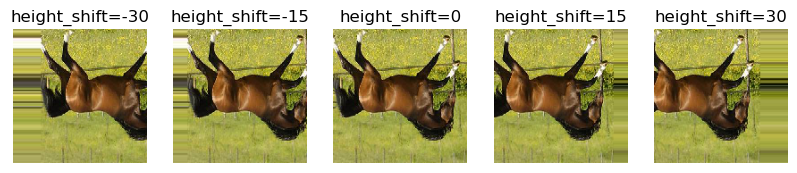

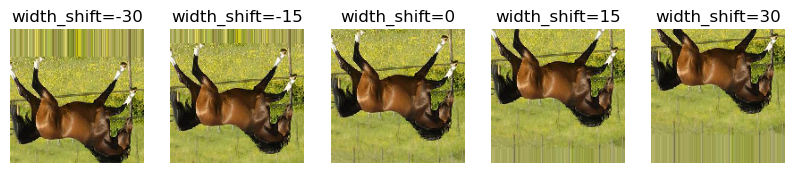

In [7]:
param = 'height_shift'
values = [-30, -15, 0, 15, 30]
show_augmentations(param, values, (10, 3))

param = 'width_shift'
values = [-30, -15, 0, 15, 30]
show_augmentations(param, values, (10, 3))

## **Shear**

Effectively, this is elongating or "pulling" the image along one corner. 

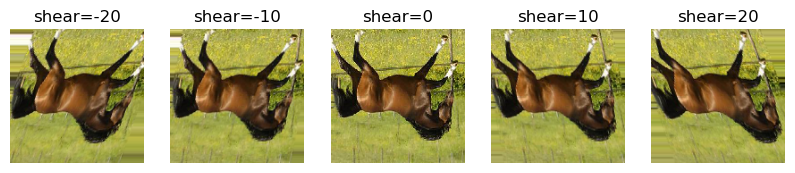

In [8]:
param = 'shear'
values = [-20, -10, 0, 10, 20]
show_augmentations(param, values, (10, 3))

## **Zoom**

We can zoom in/out along one axis only; we don't have to zoom in/out along both axes simultaneously.

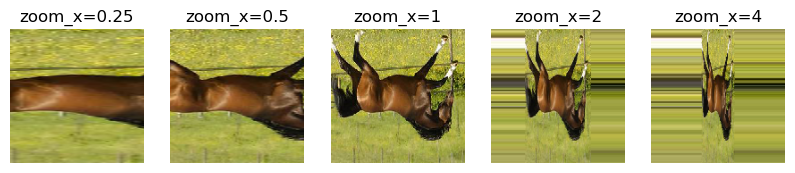

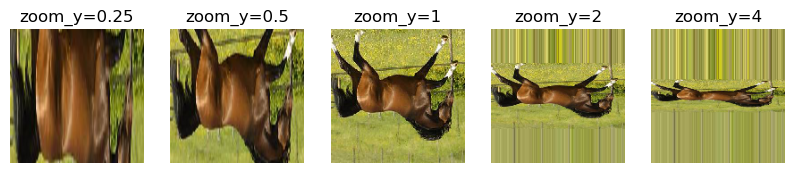

In [9]:
param = 'zoom_x'
values = [0.25, 0.5, 1, 2, 4]
show_augmentations(param, values, (10, 3))

param = 'zoom_y'
values = [0.25, 0.5, 1, 2, 4]
show_augmentations(param, values, (10, 3))

There are many other different augmentations such as changing brightness or contrast or adding patches to hide parts of the image. In addition, we can apply different augmentations simultaneously to a single image. In practical terms, we are modelling the real-life situation in which multiple images are taken of a single object at once, but due to movement etc, each image is slightly different.

In [10]:
vis_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=5.0,
    height_shift_range=5.0,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,
)

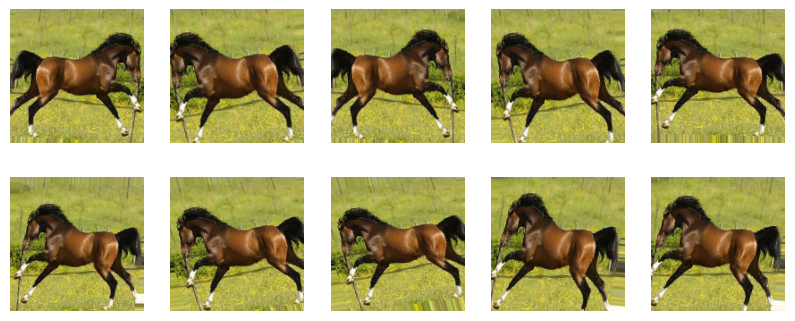

In [11]:
horse = load_img(os.path.join(horse_dir, horse_image), target_size=(150, 150))

plt.figure(figsize=(10, 4))

for i in range(10):
    t = vis_gen.get_random_transform((150, 150))
    xaug = vis_gen.apply_transform(np.array(horse), t)

    plt.subplot(2, 5, i + 1)
    plt.imshow(xaug.astype('uint8'))
    plt.axis("off")

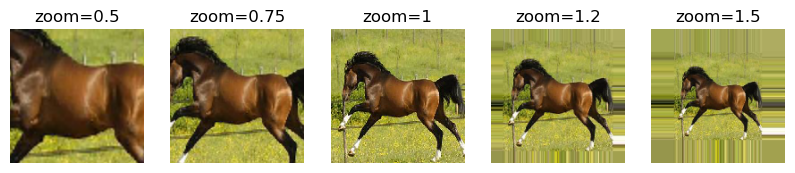

In [12]:
values = [0.5, 0.75, 1, 1.2, 1.5]

imgs = []

for v in values:
    im = augment(horse, zoom_y=v, zoom_x=v)
    imgs.append(im)

plt.figure(figsize=(10, 3))

n = len(values)

for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(np.array(imgs[i]))
    plt.title('%s=%s' % ('zoom', values[i]))
    plt.axis("off")

plt.show()